### Import Packages and Set Directories

In [1]:
import os
import sys
import json
import inspect
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy.interpolate import make_interp_spline


# Set directories
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')
data_dir = os.path.join(base_dir, 'data')
stock_dir = os.path.join(base_dir, 'data', 'stocks')
src_dir = os.path.join(base_dir, 'src')
graph_dir = os.path.join(base_dir, 'results', 'graphs')
sys.path.append(src_dir)

# Import optimal portfolio
from optimal_portfolios import OptimalPortfolios
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read in data

In [180]:
# Read portfolio weights json file
with open(os.path.join(data_dir, 'stocks/pfo_weights.json'), 'r') as json_file:
    json_dict = json.load(json_file)
pfo_weights_dict = {key: pd.read_json(json_str) for key, json_str in json_dict.items()}

# Read CSVs
stock_df = pd.read_csv(os.path.join(data_dir, 'stock_daily.csv'))
factors_weekly_df = pd.read_csv(os.path.join(data_dir, 'factors/factors_weekly.csv'))
factors_monthly_df = pd.read_csv(os.path.join(data_dir, 'factors/factors_monthly.csv'))
factors_yearly_df = pd.read_csv(os.path.join(data_dir, 'factors/factors_yearly.csv'))
NYSE_SP500 = pd.read_csv(os.path.join(data_dir, 'factors/NYSE_SP500.csv'))

# Read portfolio csvs
pfo_return = pd.read_csv(os.path.join(data_dir, 'stocks/pfo_yearly.csv'))
pfo_var = pd.read_csv(os.path.join(data_dir, 'stocks/pfo_yearly_var.csv'))

# Filter data from 1994 to 2023
year_min, year_max = 1994, 2023
# Yearly
factors_yearly_df = factors_yearly_df[(factors_yearly_df['Year'] >= year_min) & (factors_yearly_df['Year'] <= year_max)].reset_index(drop=True)
# Monthly
factors_monthly_df['Year_Month'] = pd.to_datetime(factors_monthly_df['Year_Month'])
factors_monthly_df = factors_monthly_df[(factors_monthly_df['Year_Month'].dt.year >= year_min) & (factors_monthly_df['Year_Month'].dt.year <= year_max)].reset_index(drop=True)
factors_monthly_df['Year_Month'] = factors_monthly_df['Year_Month'].dt.strftime('%Y-%m')
# Weekly
factors_weekly_df['Date'] = pd.to_datetime(factors_weekly_df['Date'])
factors_weekly_df = factors_weekly_df[(factors_weekly_df['Date'].dt.year >= year_min) & (factors_weekly_df['Date'].dt.year <= year_max)].reset_index(drop=True)
factors_weekly_df['Date'] = factors_weekly_df['Date'].dt.strftime('%Y-%m-%d')

### 1. Count number of stocks available across time

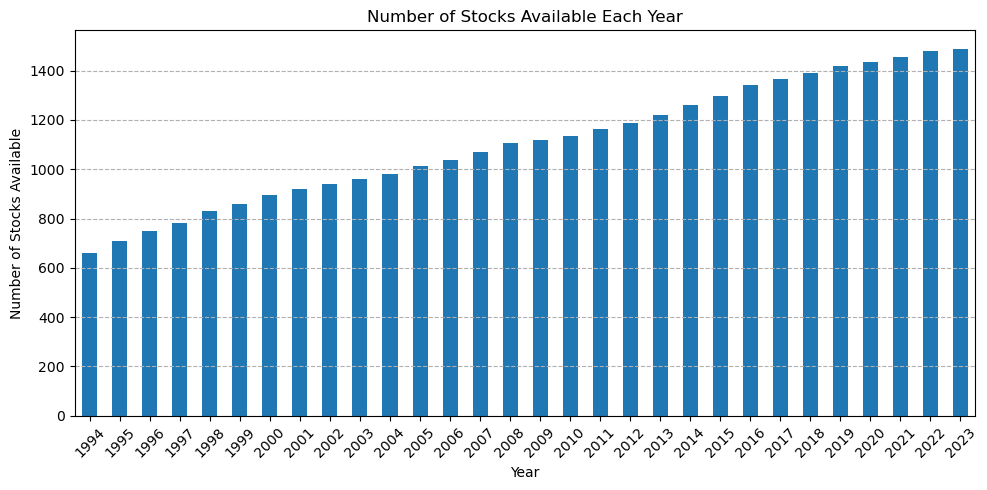

In [24]:
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Year'] = stock_df['Date'].dt.year

# Select the first day of each year
first_day_each_year = stock_df.groupby('Year').first()

# Count non-NaN values across columns for each year
non_nan_counts = first_day_each_year.count(axis=1)

# Plotting
plt.figure(figsize=(10, 5))
non_nan_counts.plot(kind='bar')

plt.xlabel('Year')
plt.ylabel('Number of Stocks Available')
plt.title('Number of Stocks Available Each Year')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.grid(True, linestyle='--', axis='y') 
plt.tight_layout()
# plt.savefig(os.path.join(graph_dir, 'num_stocks.png'))
plt.show()

### 2.1. Factor Heatmap

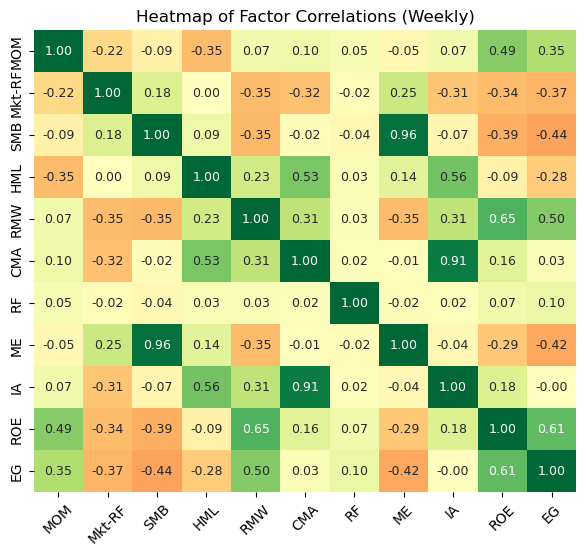

In [48]:
# Calculate correlation
corr_matrix = factors_weekly_df.corr()

# Plot
plt.figure(figsize=(7,6))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':9}, cbar=False)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.title('Heatmap of Factor Correlations (Weekly)')
# plt.savefig(os.path.join(graph_dir, 'factors_heatmap_nocap.png'))
plt.show()

### 2.2 Factor CAGR and Variance

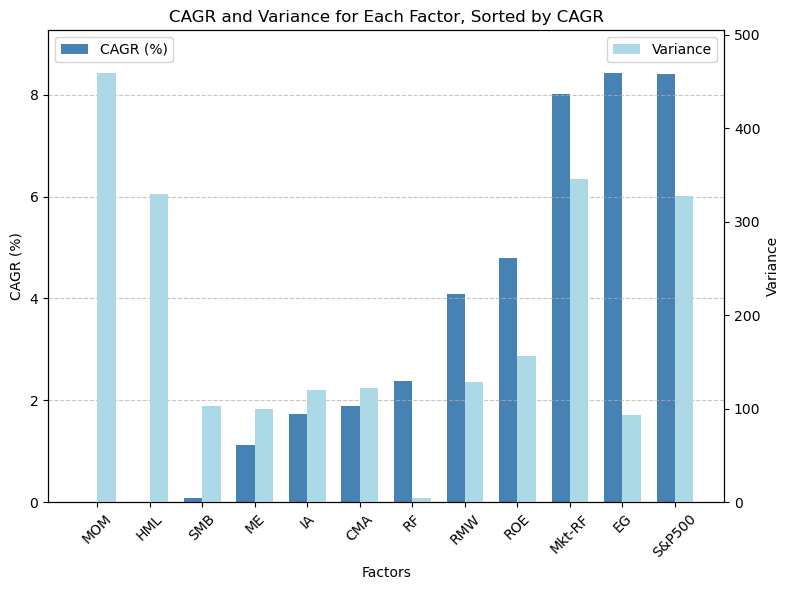

In [55]:
# Calculate CAGR for each factor
periods = factors_yearly_df['Year'].iloc[-1] - factors_yearly_df['Year'].iloc[0]
cumulative_returns = (1 + factors_yearly_df.iloc[:, 1:] / 100).cumprod() - 1
cagr_results = ((1 + cumulative_returns.iloc[-1]) ** (1 / periods) - 1) * 100

# Calculate annual variance for each factor
variance_results = factors_yearly_df.iloc[:, 1:].var(ddof=1)

# Filter NYSE_SP500 data
NYSE_SP500['Date'] = pd.to_datetime(NYSE_SP500['Date'])
min_year, max_year = factors_yearly_df['Year'].min(), factors_yearly_df['Year'].max()
NYSE_SP500 = NYSE_SP500[(NYSE_SP500['Date'].dt.year>=min_year) & (NYSE_SP500['Date'].dt.year<=max_year)]

# Resample to get annual last price
annual_df = NYSE_SP500.resample('Y', on='Date').last()
annual_returns = annual_df.pct_change().dropna() * 100

# Calculate CAGR for benchmark
def calculate_cagr(start_value, end_value, periods):
    return ((end_value / start_value) ** (1 / periods) - 1) * 100
periods = max_year - min_year
cagr_nyse = calculate_cagr(annual_df['CloseNYSE'].iloc[0], annual_df['CloseNYSE'].iloc[-1], periods)
cagr_sp500 = calculate_cagr(annual_df['CloseSP500'].iloc[0], annual_df['CloseSP500'].iloc[-1], periods)

# Calculate variance for annual returns of NYSE and S&P 500
variance_nyse = annual_returns['CloseNYSE'].var()
variance_sp500 = annual_returns['CloseSP500'].var()

# Sorting the results based on CAGR
sorted_indices = cagr_results.argsort()
sorted_cagr = cagr_results[sorted_indices]
sorted_variance = variance_results[sorted_indices]
sorted_cagr['S&P500'] = cagr_sp500  # add S&P 500 as benchmark
sorted_variance['S&P500'] = variance_sp500

# Plotting
fig, ax1 = plt.subplots(figsize=(8,6))
bar_width = 0.35  # Width of the bars
indices = np.arange(len(sorted_cagr))

# Plot CAGR results and variance
cagr_bars = ax1.bar(indices - bar_width / 2, sorted_cagr, bar_width, label='CAGR (%)', color='steelblue')
ax2 = ax1.twinx()  # Create second y-axis for the variance
variance_bars = ax2.bar(indices + bar_width / 2, sorted_variance, bar_width, label='Variance', color='lightblue')

# Set labels and title
ax1.set_xlabel('Factors')
ax1.set_ylabel('CAGR (%)')
ax2.set_ylabel('Variance')
plt.title('CAGR and Variance for Each Factor, Sorted by CAGR')
ax1.set_ylim([0, max(sorted_cagr) * 1.1])  # 10% above max for CAGR
ax2.set_ylim([0, max(sorted_variance) * 1.1])  # 10% above max for Variance

# Set x-ticks, add grid lines and legends
ax1.set_xticks(indices)
ax1.set_xticklabels(sorted_cagr.index, rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save and output
plt.tight_layout()
# plt.savefig(os.path.join(graph_dir, 'factors_return_var.png'))
plt.show()

### 2.3 Factor anomalies

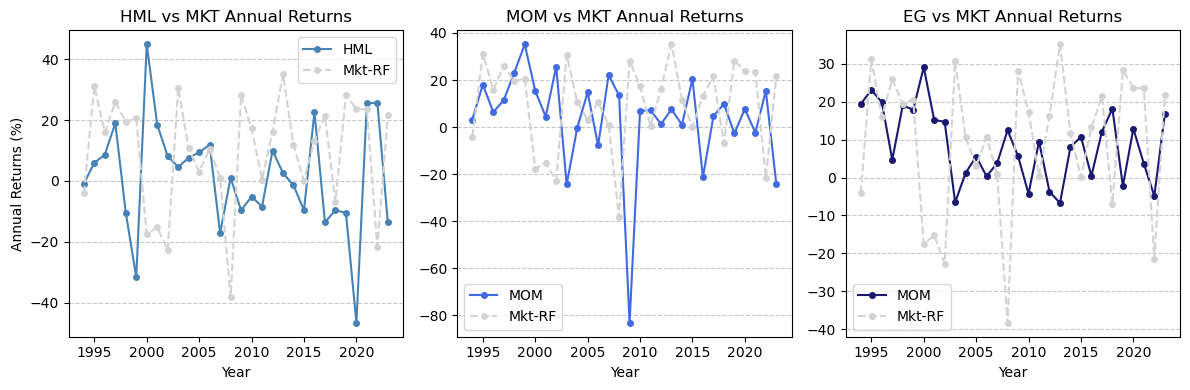

In [61]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# First subplot: 'HML' and 'Mkt-RF'
ax1.plot(factors_yearly_df['Year'], factors_yearly_df['HML'], label='HML', color='steelblue', marker='o', markersize=4)
ax1.plot(factors_yearly_df['Year'], factors_yearly_df['Mkt-RF'], label='Mkt-RF', color='lightgray', linestyle='--', marker='o', markersize=4)
ax1.set_xlabel('Year')
ax1.set_ylabel('Annual Returns (%)')
ax1.set_title('HML vs MKT Annual Returns')
ax1.legend()
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)  # Only horizontal grid lines

# Second subplot: 'MOM' and 'Mkt-RF'
ax2.plot(factors_yearly_df['Year'], factors_yearly_df['MOM'], label='MOM', color='royalblue', marker='o', markersize=4)
ax2.plot(factors_yearly_df['Year'], factors_yearly_df['Mkt-RF'], label='Mkt-RF', color='lightgray', linestyle='--', marker='o', markersize=4)
ax2.set_xlabel('Year')
ax2.set_title('MOM vs MKT Annual Returns')
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)  # Only horizontal grid lines

# Third subplot: 'EG' and 'Mkt-RF'
ax3.plot(factors_yearly_df['Year'], factors_yearly_df['EG'], label='MOM', color='midnightblue', marker='o', markersize=4)
ax3.plot(factors_yearly_df['Year'], factors_yearly_df['Mkt-RF'], label='Mkt-RF', color='lightgray', linestyle='--', marker='o', markersize=4)
ax3.set_xlabel('Year')
ax3.set_title('EG vs MKT Annual Returns')
ax3.legend()
ax3.grid(True, axis='y', linestyle='--', alpha=0.7)  # Only horizontal grid lines

# Show and save the plot
plt.tight_layout()
# plt.savefig(os.path.join(graph_dir, 'anomaly_returns.png'))
plt.show()

### 3.1 Number of Stock Used in Each Portfolio

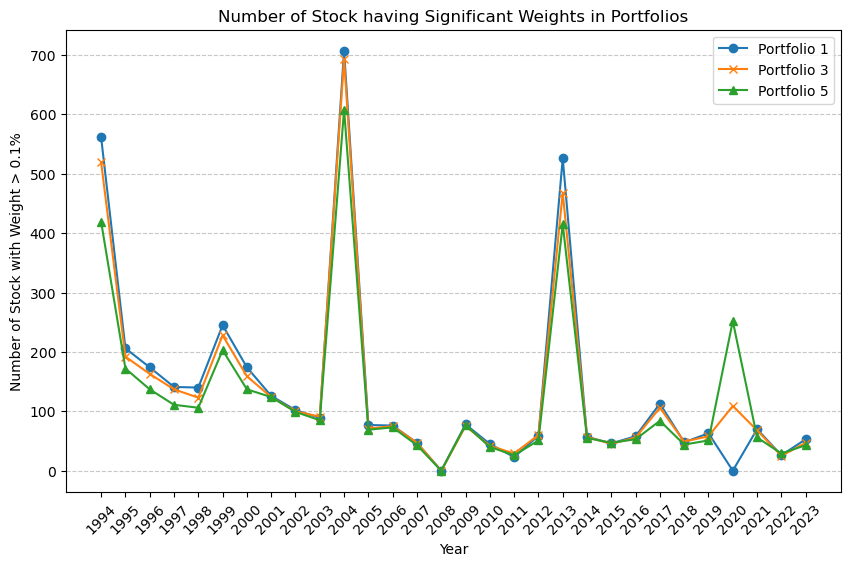

In [132]:
# Initialize an empty DataFrame for the final result
high_weight_df = pd.DataFrame(columns=['weight_1', 'weight_2', 'weight_3', 'weight_4', 'weight_5'])

# Iterate through the dictionary
threshold = 0.001
for year, df in pfo_weights_dict.items():
    # Count the number of rows where weights are greater than 0.001 for each weight column
    count_weight_1 = df[abs(df['weight_1']) > threshold].shape[0]
    count_weight_2 = df[abs(df['weight_2']) > threshold].shape[0]
    count_weight_3 = df[abs(df['weight_3']) > threshold].shape[0]
    count_weight_4 = df[abs(df['weight_4']) > threshold].shape[0]
    count_weight_5 = df[abs(df['weight_5']) > threshold].shape[0]

    # Add the counts to the result DataFrame
    high_weight_df.loc[year] = [count_weight_1, count_weight_2, count_weight_3, count_weight_4, count_weight_5]

plt.figure(figsize=(10, 6))
plt.plot(high_weight_df.index, high_weight_df['weight_1'], label='Portfolio 1', marker='o')
plt.plot(high_weight_df.index, high_weight_df['weight_3'], label='Portfolio 3', marker='x')
plt.plot(high_weight_df.index, high_weight_df['weight_5'], label='Portfolio 5', marker='^')

plt.xlabel('Year')
plt.ylabel('Number of Stock with Weight > 0.1%')
plt.title('Number of Stock having Significant Weights in Portfolios')
plt.xticks(rotation=45, fontsize=10)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
# plt.savefig(os.path.join(graph_dir, 'stock_count.png'))
plt.show()

In [176]:
# Apply condition to find rows where any weight is either 0 or exceeds 200
condition = (high_weight_df == 0) | (high_weight_df > 300)
anomaly_years = high_weight_df[condition.any(axis=1)].index.tolist()
anomaly_years = [int(year) for year in anomaly_years]

# Choose same number of normal years
normal = (high_weight_df > 50) & (high_weight_df < 150)
normal_years = high_weight_df[normal.any(axis=1)].index.tolist()
years_int = [int(year) for year in normal_years]
interval = len(years_int) // (len(anomaly_years) - 1)
selected_years = [years_int[i] for i in range(0, len(years_int), interval)][:5]
normal_years = [int(year) for year in selected_years]

# Display the years that meet the condition
print(anomaly_years)
print(normal_years)

[1994, 2004, 2008, 2013, 2020]
[1996, 2001, 2006, 2016, 2021]


### 3.2 Efficient Frontiers

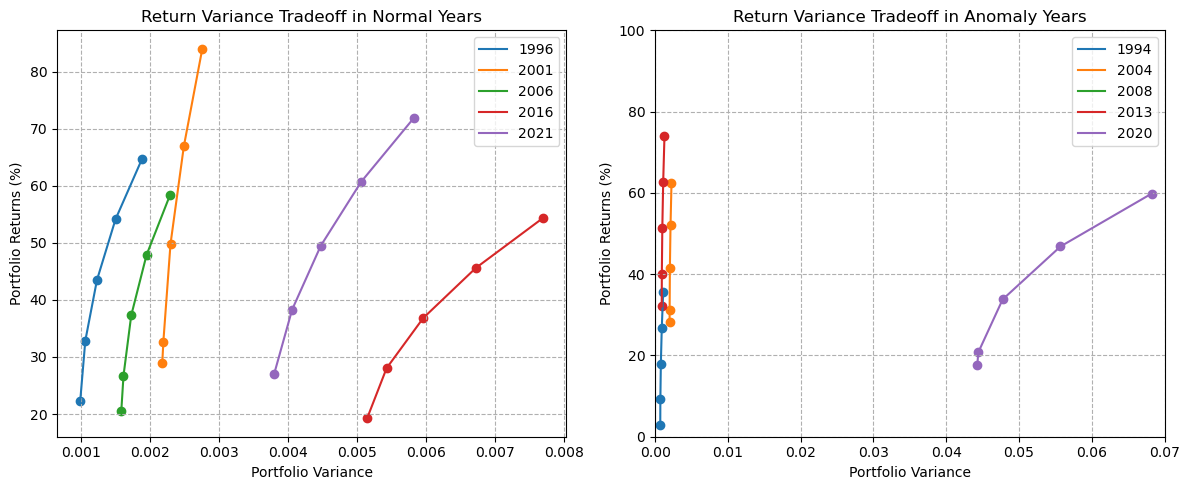

In [239]:
# Filter the DataFrame for the anomaly years
anomaly_return = pfo_return[pfo_return['Year'].isin(anomaly_years)].set_index('Year')
anomaly_var = pfo_var[pfo_var['Year'].isin(anomaly_years)].set_index('Year')

# Filter the DataFrame for normal years
normal_return = pfo_return[pfo_return['Year'].isin(normal_years)].set_index('Year')
normal_var = pfo_var[pfo_var['Year'].isin(normal_years)].set_index('Year')

# Plotting for each portfolio
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plotting for normal years
for year in normal_years:
    returns = np.array(normal_return[normal_return.index==year]).flatten() * 100
    variances = np.array(normal_var[normal_var.index==year]).flatten()
    axes[0].scatter(variances, returns)
    axes[0].plot(variances, returns, label=year)

# Setting labels and title for the first plot
axes[0].set_xlabel('Portfolio Variance')
axes[0].set_ylabel('Portfolio Returns (%)')
axes[0].set_title('Return Variance Tradeoff in Normal Years')
axes[0].legend()
axes[0].grid(True, linestyle='--')

# Plotting for anomaly years
for year in anomaly_years:
    returns = np.array(anomaly_return[anomaly_return.index==year]).flatten() * 100
    variances = np.array(anomaly_var[anomaly_var.index==year]).flatten()
    axes[1].scatter(variances, returns)
    axes[1].plot(variances, returns, label=year)

# Setting labels, title, and y-axis limits for the second plot
axes[1].set_xlabel('Portfolio Variance')
axes[1].set_ylabel('Portfolio Returns (%)')
axes[1].set_title('Return Variance Tradeoff in Anomaly Years')
axes[1].set_ylim(0, 100)  # Set y-axis limits
axes[1].set_xlim(0, 0.07)  # Set x-axis limits
axes[1].legend()
axes[1].grid(True, linestyle='--')

# Show the plot
plt.tight_layout()
# plt.savefig(os.path.join(graph_dir, 'ef_normal_vs_anomaly.png'))
plt.show()